In [ ]:
!pip install numpy pandas matplotlib seaborn scipy statsmodels h5py scanpy biopython pyarrow rpy2 gdown tqdm subread htseq
%load_ext rpy2.ipython
!%%R
!install.packages(c("BiocManager"), repos="http://cran.us.r-project.org")
!BiocManager::install(c("edgeR", "limma", "DESeq2", "ggplot2", "pheatmap", "clusterProfiler", "org.Hs.eg.db"))
!%%R
!library(edgeR)
print("edgeR successfully installed and loaded!")

  Using cached biopython-1.85-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
ERROR: Could not find a version that satisfies the requirement subread (from versions: none)
ERROR: No matching distribution found for subread
/bin/bash: line 1: fg: no job control
/bin/bash: -c: line 1: syntax error near unexpected token `c'
/bin/bash: -c: line 1: `install.packages(c("BiocManager"), repos="http://cran.us.r-project.org")'
/bin/bash: -c: line 1: syntax error near unexpected token `c'
/bin/bash: -c: line 1: `BiocManager::install(c("edgeR", "limma", "DESeq2", "ggplot2", "pheatmap", "clusterProfiler", "org.Hs.eg.db"))'
/bin/bash: line 1: fg: no job control
/bin/bash: -c: line 1: syntax error near unexpected token `edgeR'
/bin/bash: -c: line 1: `library(edgeR)'
edgeR successfully installed and loaded!


In [ ]:

!apt install subread

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
subread is already the newest version (2.0.3+dfsg-1).
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.


In [ ]:
!apt-get install -y sra-toolkit

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  blends-common libkdf5-2 libncbi-vdb2 libncbi-wvdb2 med-config menu
Suggested packages:
  blends-doc menu-l10n gksu | kde-runtime | ktsuss
The following NEW packages will be installed:
  blends-common libkdf5-2 libncbi-vdb2 libncbi-wvdb2 med-config menu sra-toolkit
0 upgraded, 7 newly installed, 0 to remove and 21 not upgraded.
Need to get 8,290 kB of archives.
After this operation, 23.0 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 menu amd64 2.1.47ubuntu4 [354 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 blends-common all 0.7.4ubuntu1 [15.9 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libkdf5-2 amd64 2.11.2+dfsg-4build2 [14.7 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libncbi-vdb2 amd64 2.11.2+dfsg-4build2 [1,364 kB]
Get:5

In [ ]:
!pip install scanpy

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import h5py
import pyarrow
import subprocess

from tqdm import tqdm
from scipy import stats
from statsmodels.stats.multitest import multipletests
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri

# Activate automatic conversion between R and pandas DataFrames
pandas2ri.activate()

# Set visualization styles
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

print("All packages installed and ready to use!")

All packages installed and ready to use!


In [ ]:
# Define metadata
metadata = pd.DataFrame({
    "Sample_Name": ["N061011_untreated", "N080611_untreated", "N052611_untreated",
                    "N061011_Dex", "N080611_Dex", "N052611_Dex"],
    "SRA_Accession": ["SRR1039520", "SRR1039516", "SRR1039512",
                      "SRR1039521", "SRR1039517", "SRR1039513"],
    "Condition": ["Untreated", "Untreated", "Untreated",
                  "Dex", "Dex", "Dex"],
    "Batch": ["N061011", "N080611", "N052611",
              "N061011", "N080611", "N052611"]
})

# Save to CSV
metadata.to_csv("metadata.csv", index=False)
print("Metadata file created: metadata.csv")


Metadata file created: metadata.csv


In [ ]:
# Read metadata
metadata = pd.read_csv("metadata.csv")

# Create directory for FASTQ files
os.makedirs("RNAseq_FASTQ", exist_ok=True)

# Loop through each sample and download its FASTQ file
for accession in metadata["SRA_Accession"]:
    print(f"Downloading {accession}...")
    os.system(f"prefetch {accession}")
    os.system(f"fastq-dump --split-files --gzip --outdir RNAseq_FASTQ {accession}")
    os.system(f"rm -r /content/{accession}")

print("All FASTQ files downloaded successfully!")


All FASTQ files downloaded successfully!


In [ ]:
!apt-get install -y fastqc

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  default-jre default-jre-headless fonts-dejavu-core fonts-dejavu-extra libapache-pom-java
  libargs4j-java libatk-wrapper-java libatk-wrapper-java-jni libcommons-compress-java
  libcommons-io-java libcommons-jexl2-java libcommons-lang3-java libcommons-logging-java
  libcommons-math3-java libcommons-parent-java libfindbin-libs-perl libfontenc1 libhtsjdk-java
  libjbzip2-java libjson-simple-java libngs-java libngs-sdk-dev libngs-sdk2 libsis-base-java
  libsis-base-jni libsis-jhdf5-java libsis-jhdf5-jni libsnappy-java libsnappy-jni libxkbfile1
  libxtst6 libxxf86dga1 openjdk-11-jre x11-utils
Suggested packages:
  libxz-java libcommons-io-java-doc libcommons-lang3-java-doc libavalon-framework-java
  libcommons-logging-java-doc libexcalibur-logkit-java liblog4j1.2-java picard-tools
  libjson-simple-doc mesa-utils
The following NEW packages wi

In [ ]:
!mkdir -p RNAseq_FASTQ/QC_Reports

# Run FastQC on all FASTQ files
!fastqc RNAseq_FASTQ/*.fastq.gz --outdir=RNAseq_FASTQ/QC_Reports

In [ ]:
!apt-get install -y hisat2

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  bcftools libhts3 libhtscodecs2 python3-hisat2 samtools
Suggested packages:
  python3-numpy python3-matplotlib texlive-latex-recommended cwltool
The following NEW packages will be installed:
  bcftools hisat2 libhts3 libhtscodecs2 python3-hisat2 samtools
0 upgraded, 6 newly installed, 0 to remove and 21 not upgraded.
Need to get 5,505 kB of archives.
After this operation, 17.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libhtscodecs2 amd64 1.1.1-3 [53.2 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libhts3 amd64 1.13+ds-2build1 [390 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 bcftools amd64 1.13-1 [697 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 hisat2 amd64 2.2.1-3 [3,832 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy/un

In [ ]:
!mkdir -p reference_genome
!wget -P reference_genome/ https://genome-idx.s3.amazonaws.com/hisat/grch38_genome.tar.gz
!tar -xzvf /content/reference_genome/grch38_genome.tar.gz -C reference_genome/
!wget -O reference_genome/gencode.v47.annotation.gtf.gz https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_47/gencode.v47.annotation.gtf.gz
!gunzip reference_genome/gencode.v47.annotation.gtf.gz


--2025-02-22 08:13:35--  https://genome-idx.s3.amazonaws.com/hisat/grch38_genome.tar.gz
Resolving genome-idx.s3.amazonaws.com (genome-idx.s3.amazonaws.com)... 54.231.159.33, 52.217.14.68, 3.5.28.42, ...
Connecting to genome-idx.s3.amazonaws.com (genome-idx.s3.amazonaws.com)|54.231.159.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4210306865 (3.9G) [binary/octet-stream]
Saving to: ‘reference_genome/grch38_genome.tar.gz’

grch38_genome.tar.g 100%[===================>]   3.92G  17.8MB/s    in 2m 56s  

2025-02-22 08:16:31 (22.8 MB/s) - ‘reference_genome/grch38_genome.tar.gz’ saved [4210306865/4210306865]

grch38/
grch38/genome.5.ht2
grch38/genome.2.ht2
grch38/make_grch38.sh
grch38/genome.3.ht2
grch38/genome.4.ht2
grch38/genome.7.ht2
grch38/genome.1.ht2
grch38/genome.6.ht2
grch38/genome.8.ht2
--2025-02-22 08:17:15--  https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_47/gencode.v47.annotation.gtf.gz
Resolving ftp.ebi.ac.uk (ftp.ebi.ac.uk)... 19

In [ ]:
!apt-get install -y samtools  # Install samtools if not installed

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
samtools is already the newest version (1.13-4).
samtools set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.


In [ ]:
import os
import multiprocessing

# Find available CPU cores
num_cores = multiprocessing.cpu_count()
threads = min(16, num_cores)  # Use up to 16 cores but not exceed available

# Define paths
hisat2_index = "/content/reference_genome/grch38/grch38"  # Corrected Path
input_folder = "RNAseq_FASTQ"
output_folder = "RNAseq_BAM"
os.makedirs(output_folder, exist_ok=True)

# Get list of all FASTQ files
fastq_files = sorted([f for f in os.listdir(input_folder) if f.endswith(".fastq.gz")])

# Align each paired-end sample
for i in range(0, len(fastq_files), 2):  # Processing in pairs
    sample_name = fastq_files[i].split("_1.fastq.gz")[0]  # Extract sample name
    read1 = os.path.join(input_folder, fastq_files[i])    # Forward read file
    read2 = os.path.join(input_folder, fastq_files[i+1])  # Reverse read file
    output_bam = os.path.join(output_folder, f"{sample_name}.bam")

    # Run HISAT2 with Read Groups added
    print(f"Aligning {sample_name} using {threads} threads...")
    os.system(f"""
        hisat2 -p {threads} --dta --min-intronlen 20 --max-intronlen 500000 -x {hisat2_index} -1 {read1} -2 {read2} | \
        samtools view -bS - | \
        samtools addreplacerg -r '@RG\\tID:{sample_name}\\tSM:{sample_name}\\tPL:ILLUMINA' - | \
        samtools sort -@ {threads} -m 6G -o {output_bam}
    """)

    # Index the BAM file immediately
    os.system(f"samtools index {output_bam}")

print("Alignment completed. BAM files (with RG) are saved in RNAseq_BAM/")


Aligning SRR1039512 using 8 threads...
Aligning SRR1039513 using 8 threads...
Aligning SRR1039516 using 8 threads...
Aligning SRR1039517 using 8 threads...
Aligning SRR1039520 using 8 threads...
Aligning SRR1039521 using 8 threads...
Alignment completed. BAM files (with RG) are saved in RNAseq_BAM/


In [ ]:
!cp -r /content/RNAseq_BAM/ /content/drive/MyDrive/Bulk_RNA/

In [ ]:
# Iterate over all BAM files and check alignment quality
for bam_file in os.listdir("RNAseq_BAM"):
    if bam_file.endswith(".bam"):
        print(f"\nChecking {bam_file} alignment quality:")

        # Run samtools flagstat and capture output
        result = subprocess.run(f"samtools flagstat RNAseq_BAM/{bam_file}", shell=True, capture_output=True, text=True)

        # Print the actual output
        print(result.stdout)


Checking SRR1039520.bam alignment quality:
45068463 + 0 in total (QC-passed reads + QC-failed reads)
42551720 + 0 primary
2516743 + 0 secondary
0 + 0 supplementary
0 + 0 duplicates
0 + 0 primary duplicates
43565850 + 0 mapped (96.67% : N/A)
41049107 + 0 primary mapped (96.47% : N/A)
42551720 + 0 paired in sequencing
21275860 + 0 read1
21275860 + 0 read2
39501618 + 0 properly paired (92.83% : N/A)
39843424 + 0 with itself and mate mapped
1205683 + 0 singletons (2.83% : N/A)
181058 + 0 with mate mapped to a different chr
153637 + 0 with mate mapped to a different chr (mapQ>=5)


Checking SRR1039512.bam alignment quality:
59680750 + 0 in total (QC-passed reads + QC-failed reads)
56272564 + 0 primary
3408186 + 0 secondary
0 + 0 supplementary
0 + 0 duplicates
0 + 0 primary duplicates
57973770 + 0 mapped (97.14% : N/A)
54565584 + 0 primary mapped (96.97% : N/A)
56272564 + 0 paired in sequencing
28136282 + 0 read1
28136282 + 0 read2
52782362 + 0 properly paired (93.80% : N/A)
53205792 + 0 wi

In [ ]:
!apt install openjdk-17-jdk
!wget -O picard.jar https://github.com/broadinstitute/picard/releases/latest/download/picard.jar

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libice-dev libsm-dev libxt-dev openjdk-17-jdk-headless openjdk-17-jre openjdk-17-jre-headless
Suggested packages:
  libice-doc libsm-doc libxt-doc openjdk-17-demo openjdk-17-source visualvm libnss-mdns
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei | fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libice-dev libsm-dev libxt-dev openjdk-17-jdk openjdk-17-jdk-headless openjdk-17-jre
  openjdk-17-jre-headless
0 upgraded, 7 newly installed, 0 to remove and 21 not upgraded.
Need to get 122 MB of archives.
After this operation, 275 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libice-dev amd64 2:1.0.10-1build2 [51.4 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libsm-dev amd64 2:1.2.3-1build2 [18.1 kB]
Get:3 http://archive.ubuntu.com

In [ ]:
import os

# Define paths
input_folder = "RNAseq_BAM"
output_folder = "RNAseq_BAM_Deduplicated"
metrics_folder = "RNAseq_BAM_Deduplicated/Metrics"
os.makedirs(output_folder, exist_ok=True)
os.makedirs(metrics_folder, exist_ok=True)

# Process each BAM file
for bam_file in os.listdir(input_folder):
    if bam_file.endswith(".bam"):
        sample_name = bam_file.replace(".bam", "")
        input_bam = os.path.join(input_folder, bam_file)
        output_bam = os.path.join(output_folder, f"{sample_name}_dedup.bam")
        metrics_file = os.path.join(metrics_folder, f"{sample_name}_metrics.txt")

        print(f"\nProcessing {bam_file} - Removing PCR duplicates...")

        # Run Picard MarkDuplicates
        os.system(f"""
            java -jar picard.jar MarkDuplicates \
            I={input_bam} \
            O={output_bam} \
            M={metrics_file} \
            REMOVE_DUPLICATES=true \
            ASSUME_SORTED=true \
            VALIDATION_STRINGENCY=LENIENT
        """)

print("\nDuplicate removal completed! Deduplicated BAM files are in RNAseq_BAM_Deduplicated/")



Processing SRR1039520.bam - Removing PCR duplicates...

Processing SRR1039512.bam - Removing PCR duplicates...

Processing SRR1039517.bam - Removing PCR duplicates...

Processing SRR1039513.bam - Removing PCR duplicates...

Processing SRR1039516.bam - Removing PCR duplicates...

Processing SRR1039521.bam - Removing PCR duplicates...

Duplicate removal completed! Deduplicated BAM files are in RNAseq_BAM_Deduplicated/


In [ ]:
!cp -r /content/RNAseq_BAM_Deduplicated /content/drive/MyDrive/Bulk_RNA/

In [ ]:
!samtools flagstat /content/RNAseq_BAM_Deduplicated/SRR1039512_dedup.bam

48252687 + 0 in total (QC-passed reads + QC-failed reads)
44844501 + 0 primary
3408186 + 0 secondary
0 + 0 supplementary
0 + 0 duplicates
0 + 0 primary duplicates
46545707 + 0 mapped (96.46% : N/A)
43137521 + 0 primary mapped (96.19% : N/A)
44844501 + 0 paired in sequencing
22372111 + 0 read1
22472390 + 0 read2
42356406 + 0 properly paired (94.45% : N/A)
42747916 + 0 with itself and mate mapped
389605 + 0 singletons (0.87% : N/A)
202424 + 0 with mate mapped to a different chr
166668 + 0 with mate mapped to a different chr (mapQ>=5)


In [ ]:
!cp -r /content/drive/MyDrive/Bulk_RNA/RNAseq_BAM_Deduplicated/ /content/

In [ ]:
bam_folder = "RNAseq_BAM_Deduplicated"
output_counts = "RNAseq_Counts/gene_counts.txt"
gtf_file = "reference_genome/gencode.v47.annotation.gtf"

# Create output directory
os.makedirs("RNAseq_Counts", exist_ok=True)

# Get all BAM file paths
bam_files = [os.path.join(bam_folder, f) for f in os.listdir(bam_folder) if f.endswith(".bam")]

# Run FeatureCounts
os.system(f"""
    featureCounts -T 8 -p -t exon -g gene_id -a {gtf_file} -o {output_counts} {' '.join(bam_files)}
""")

print("\nFeatureCounts completed! Gene count matrix saved at RNAseq_Counts/gene_counts.txt")



FeatureCounts completed! Gene count matrix saved at RNAseq_Counts/gene_counts.txt


In [ ]:
!head -n 20 RNAseq_Counts/gene_counts.txt

# Program:featureCounts v2.0.3; Command:"featureCounts" "-T" "8" "-p" "-t" "exon" "-g" "gene_id" "-a" "reference_genome/gencode.v47.annotation.gtf" "-o" "RNAseq_Counts/gene_counts.txt" "RNAseq_BAM_Deduplicated/SRR1039517_dedup.bam" "RNAseq_BAM_Deduplicated/SRR1039520_dedup.bam" "RNAseq_BAM_Deduplicated/SRR1039513_dedup.bam" "RNAseq_BAM_Deduplicated/SRR1039512_dedup.bam" "RNAseq_BAM_Deduplicated/SRR1039521_dedup.bam" "RNAseq_BAM_Deduplicated/SRR1039516_dedup.bam" 
Geneid	Chr	Start	End	Strand	Length	RNAseq_BAM_Deduplicated/SRR1039517_dedup.bam	RNAseq_BAM_Deduplicated/SRR1039520_dedup.bam	RNAseq_BAM_Deduplicated/SRR1039513_dedup.bam	RNAseq_BAM_Deduplicated/SRR1039512_dedup.bam	RNAseq_BAM_Deduplicated/SRR1039521_dedup.bam	RNAseq_BAM_Deduplicated/SRR1039516_dedup.bam
ENSG00000290825.2	chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1

In [ ]:
!wc -l /content/RNAseq_Counts/gene_counts.txt

78726 /content/RNAseq_Counts/gene_counts.txt


In [ ]:
import pandas as pd
from rpy2.robjects import pandas2ri, r
pandas2ri.activate()

# Load your count matrix
# (Assume you have pre-processed the file so that the first column is gene IDs and subsequent columns are samples)
counts = pd.read_csv("RNAseq_Counts/gene_counts.txt", sep="\t", comment="#", index_col=0)

# file includes annotation columns, drop them.
counts = counts.iloc[:, 5:]

# Load your metadata (make sure the index or a specific column matches your count column names)
metadata = pd.read_csv("metadata.csv", index_col=0)


In [ ]:
counts.head()

,RNAseq_BAM_Deduplicated/SRR1039517_dedup.bam,RNAseq_BAM_Deduplicated/SRR1039520_dedup.bam,RNAseq_BAM_Deduplicated/SRR1039513_dedup.bam,RNAseq_BAM_Deduplicated/SRR1039512_dedup.bam,RNAseq_BAM_Deduplicated/SRR1039521_dedup.bam,RNAseq_BAM_Deduplicated/SRR1039516_dedup.bam
Geneid,,,,,,
ENSG00000290825.2,0,0,1,0,0,0
ENSG00000223972.6,0,0,0,0,0,0
ENSG00000310526.1,58,63,67,106,76,49
ENSG00000227232.6,0,0,0,0,0,0
ENSG00000278267.1,0,0,0,0,0,0


In [ ]:
!%%R
#!install.packages("BiocManager")
!BiocManager::install("DESeq2")
!library(DESeq2)

/bin/bash: line 1: fg: no job control
/bin/bash: -c: line 1: syntax error near unexpected token `"DESeq2"'
/bin/bash: -c: line 1: `BiocManager::install("DESeq2")'
/bin/bash: -c: line 1: syntax error near unexpected token `DESeq2'
/bin/bash: -c: line 1: `library(DESeq2)'


In [ ]:

# Install BiocManager and DESeq2
#robjects.r('install.packages("BiocManager")')
ro.r('BiocManager::install("DESeq2")')

# Load DESeq2
ro.r('library(DESeq2)')

'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com



  `force = TRUE` to re-install: 'DESeq2' 




Attaching package: ‘BiocGenerics’



    IQR, mad, sd, var, xtabs



    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, saveRDS, setdiff,
    table, tapply, union, unique, unsplit, which.max, which.min


Attaching package: ‘S4Vectors’



    findMatches



    expand.grid, I, unname








Attaching package: ‘MatrixGenerics’



    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colM

In [ ]:
r_counts = pandas2ri.py2rpy(counts)
r_metadata = pandas2ri.py2rpy(metadata)


In [ ]:
# Create the DESeqDataSet
dds = r('DESeqDataSetFromMatrix')(countData=r_counts,
                                  colData=r_metadata,
                                  design=r('~ Condition'))

  the rownames and colnames of the supplied assay(s) must be NULL or
  identical to those of the SummarizedExperiment object (or derivative)
  to construct



RRuntimeError: Error in SummarizedExperiment(assays = SimpleList(counts = countData),  : 
  the rownames and colnames of the supplied assay(s) must be NULL or
  identical to those of the SummarizedExperiment object (or derivative)
  to construct


In [ ]:
counts.head()

,RNAseq_BAM_Deduplicated/SRR1039517_dedup.bam,RNAseq_BAM_Deduplicated/SRR1039520_dedup.bam,RNAseq_BAM_Deduplicated/SRR1039513_dedup.bam,RNAseq_BAM_Deduplicated/SRR1039512_dedup.bam,RNAseq_BAM_Deduplicated/SRR1039521_dedup.bam,RNAseq_BAM_Deduplicated/SRR1039516_dedup.bam
Geneid,,,,,,
ENSG00000290825.2,0,0,1,0,0,0
ENSG00000223972.6,0,0,0,0,0,0
ENSG00000310526.1,58,63,67,106,76,49
ENSG00000227232.6,0,0,0,0,0,0
ENSG00000278267.1,0,0,0,0,0,0


In [ ]:
metadata.head()

,SRA_Accession,Condition,Batch
Sample_Name,,,
N061011_untreated,SRR1039520,Untreated,N061011
N080611_untreated,SRR1039516,Untreated,N080611
N052611_untreated,SRR1039512,Untreated,N052611
N061011_Dex,SRR1039521,Dex,N061011
N080611_Dex,SRR1039517,Dex,N080611


In [ ]:
counts.columns = [col.split("/")[-1].replace("_dedup.bam", "") for col in counts.columns]
counts.head()

,SRR1039517,SRR1039520,SRR1039513,SRR1039512,SRR1039521,SRR1039516
Geneid,,,,,,
ENSG00000290825.2,0,0,1,0,0,0
ENSG00000223972.6,0,0,0,0,0,0
ENSG00000310526.1,58,63,67,106,76,49
ENSG00000227232.6,0,0,0,0,0,0
ENSG00000278267.1,0,0,0,0,0,0


In [ ]:
metadata.set_index("SRA_Accession", inplace=False)

,Sample_Name,Condition,Batch
SRA_Accession,,,
SRR1039520,N061011_untreated,Untreated,N061011
SRR1039516,N080611_untreated,Untreated,N080611
SRR1039512,N052611_untreated,Untreated,N052611
SRR1039521,N061011_Dex,Dex,N061011
SRR1039517,N080611_Dex,Dex,N080611
SRR1039513,N052611_Dex,Dex,N052611


In [ ]:
metadata.set_index("SRA_Accession", inplace=True)

In [ ]:
metadata.head()

,Sample_Name,Condition,Batch
SRA_Accession,,,
SRR1039520,N061011_untreated,Untreated,N061011
SRR1039516,N080611_untreated,Untreated,N080611
SRR1039512,N052611_untreated,Untreated,N052611
SRR1039521,N061011_Dex,Dex,N061011
SRR1039517,N080611_Dex,Dex,N080611


In [ ]:
counts = counts[sorted(counts.columns)]  # Sort columns alphabetically
counts.head()

,SRR1039512,SRR1039513,SRR1039516,SRR1039517,SRR1039520,SRR1039521
Geneid,,,,,,
ENSG00000290825.2,0,1,0,0,0,0
ENSG00000223972.6,0,0,0,0,0,0
ENSG00000310526.1,106,67,49,58,63,76
ENSG00000227232.6,0,0,0,0,0,0
ENSG00000278267.1,0,0,0,0,0,0


In [ ]:
metadata = metadata.sort_index()  # Sort rows based on index (SRA_Accession)

In [ ]:
pandas2ri.activate()

# Load DESeq2 in R
ro.r('library(DESeq2)')

# Assign `dds` in R's environment
ro.globalenv['r_counts'] = pandas2ri.conversion.py2rpy(counts)
ro.globalenv['r_metadata'] = pandas2ri.conversion.py2rpy(metadata)

ro.r('''
dds <- DESeqDataSetFromMatrix(countData = r_counts,
                              colData = r_metadata,
                              design = ~ Condition)
''')

In [ ]:
# In R, one common filter is to keep genes with at least a total of 10 counts across all samples:
from rpy2.robjects import pandas2ri, r
r('''
keep <- rowSums(counts(dds)) >= 10
dds <- dds[keep, ]
''')


  error in evaluating the argument 'x' in selecting a method for function 'rowSums': error in evaluating the argument 'object' in selecting a method for function 'counts': object 'dds' not found



RRuntimeError: Error in h(simpleError(msg, call)) : 
  error in evaluating the argument 'x' in selecting a method for function 'rowSums': error in evaluating the argument 'object' in selecting a method for function 'counts': object 'dds' not found


In [ ]:
print(dds)

class: DESeqDataSet 
dim: 78724 6 
metadata(1): version
assays(1): counts
rownames(78724): ENSG00000290825.2 ENSG00000223972.6 ...
  ENSG00000210195.2 ENSG00000210196.2
rowData names(0):
colnames(6): SRR1039512 SRR1039513 ... SRR1039520 SRR1039521
colData names(3): Sample_Name Condition Batch



In [ ]:
ro.r('''
keep <- rowSums(counts(dds)) >= 10
dds <- dds[keep, ]
''')

print("✅ Low-count genes filtered!")


✅ Low-count genes filtered!


In [ ]:
r('dds <- DESeq(dds)')


In [ ]:
res = r('results(dds, contrast=c("Condition", "Dex", "Untreated"))')


In [ ]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri

pandas2ri.activate()

# Convert RS4 object to an R dataframe
ro.r('res_df <- as.data.frame(res)')

# Convert to Pandas DataFrame
df_res = pandas2ri.conversion.rpy2py(ro.r('res_df'))

# Display first few rows
print(df_res.head())


  error in evaluating the argument 'x' in selecting a method for function 'as.data.frame': object 'res' not found



RRuntimeError: Error in h(simpleError(msg, call)) : 
  error in evaluating the argument 'x' in selecting a method for function 'as.data.frame': object 'res' not found


In [ ]:
print(res)

log2 fold change (MLE): Condition Dex vs Untreated 
Wald test p-value: Condition Dex vs Untreated 
DataFrame with 25688 rows and 6 columns
                     baseMean log2FoldChange     lfcSE       stat    pvalue
                    <numeric>      <numeric> <numeric>  <numeric> <numeric>
ENSG00000310526.1    71.24575      0.1452697  0.439295   0.330688  0.740880
ENSG00000241860.8     2.97801      0.9401247  2.668259   0.352336  0.724586
ENSG00000310527.1    65.47555      0.0511055  0.417794   0.122322  0.902644
ENSG00000292994.2     7.73027     -1.1336802  1.029584  -1.101105  0.270851
ENSG00000290385.2    17.44790     -0.1251448  0.530563  -0.235872  0.813532
...                       ...            ...       ...        ...       ...
ENSG00000012817.16 1330.27356      -0.199762   2.19285 -0.0910971  0.927415
ENSG00000288049.2    10.19923      -0.537834   1.48649 -0.3618140  0.717491
ENSG00000229236.4     8.71847       0.616113   1.46061  0.4218197  0.673157
ENSG00000198692.10  324.2

In [ ]:
import rpy2.robjects as ro

# Run DESeq2 and store results in R's environment
ro.r('''
dds <- DESeq(dds)  # Perform differential expression analysis
res <- results(dds)  # Get DESeq2 results
''')

print("✅ DESeq2 results stored in R!")


✅ DESeq2 results stored in R!


In [ ]:
# Convert DESeq2 results to an R data frame
ro.r('res_df <- as.data.frame(res)')

# Convert to Pandas DataFrame
from rpy2.robjects import pandas2ri
pandas2ri.activate()

df_res = pandas2ri.conversion.rpy2py(ro.r('res_df'))

# Show first few rows
print(df_res.head())


                    baseMean  log2FoldChange     lfcSE      stat    pvalue  \
ENSG00000310526.1  71.245749       -0.145270  0.439295 -0.330688  0.740880   
ENSG00000241860.8   2.978008       -0.940125  2.668259 -0.352336  0.724586   
ENSG00000310527.1  65.475552       -0.051105  0.417794 -0.122322  0.902644   
ENSG00000292994.2   7.730266        1.133680  1.029584  1.101105  0.270851   
ENSG00000290385.2  17.447904        0.125145  0.530563  0.235872  0.813532   

                       padj  
ENSG00000310526.1  0.927685  
ENSG00000241860.8       NaN  
ENSG00000310527.1  0.974801  
ENSG00000292994.2       NaN  
ENSG00000290385.2  0.947009  


In [ ]:
r('plotMA(dds, main="MA Plot", ylim=c(-5,5))')


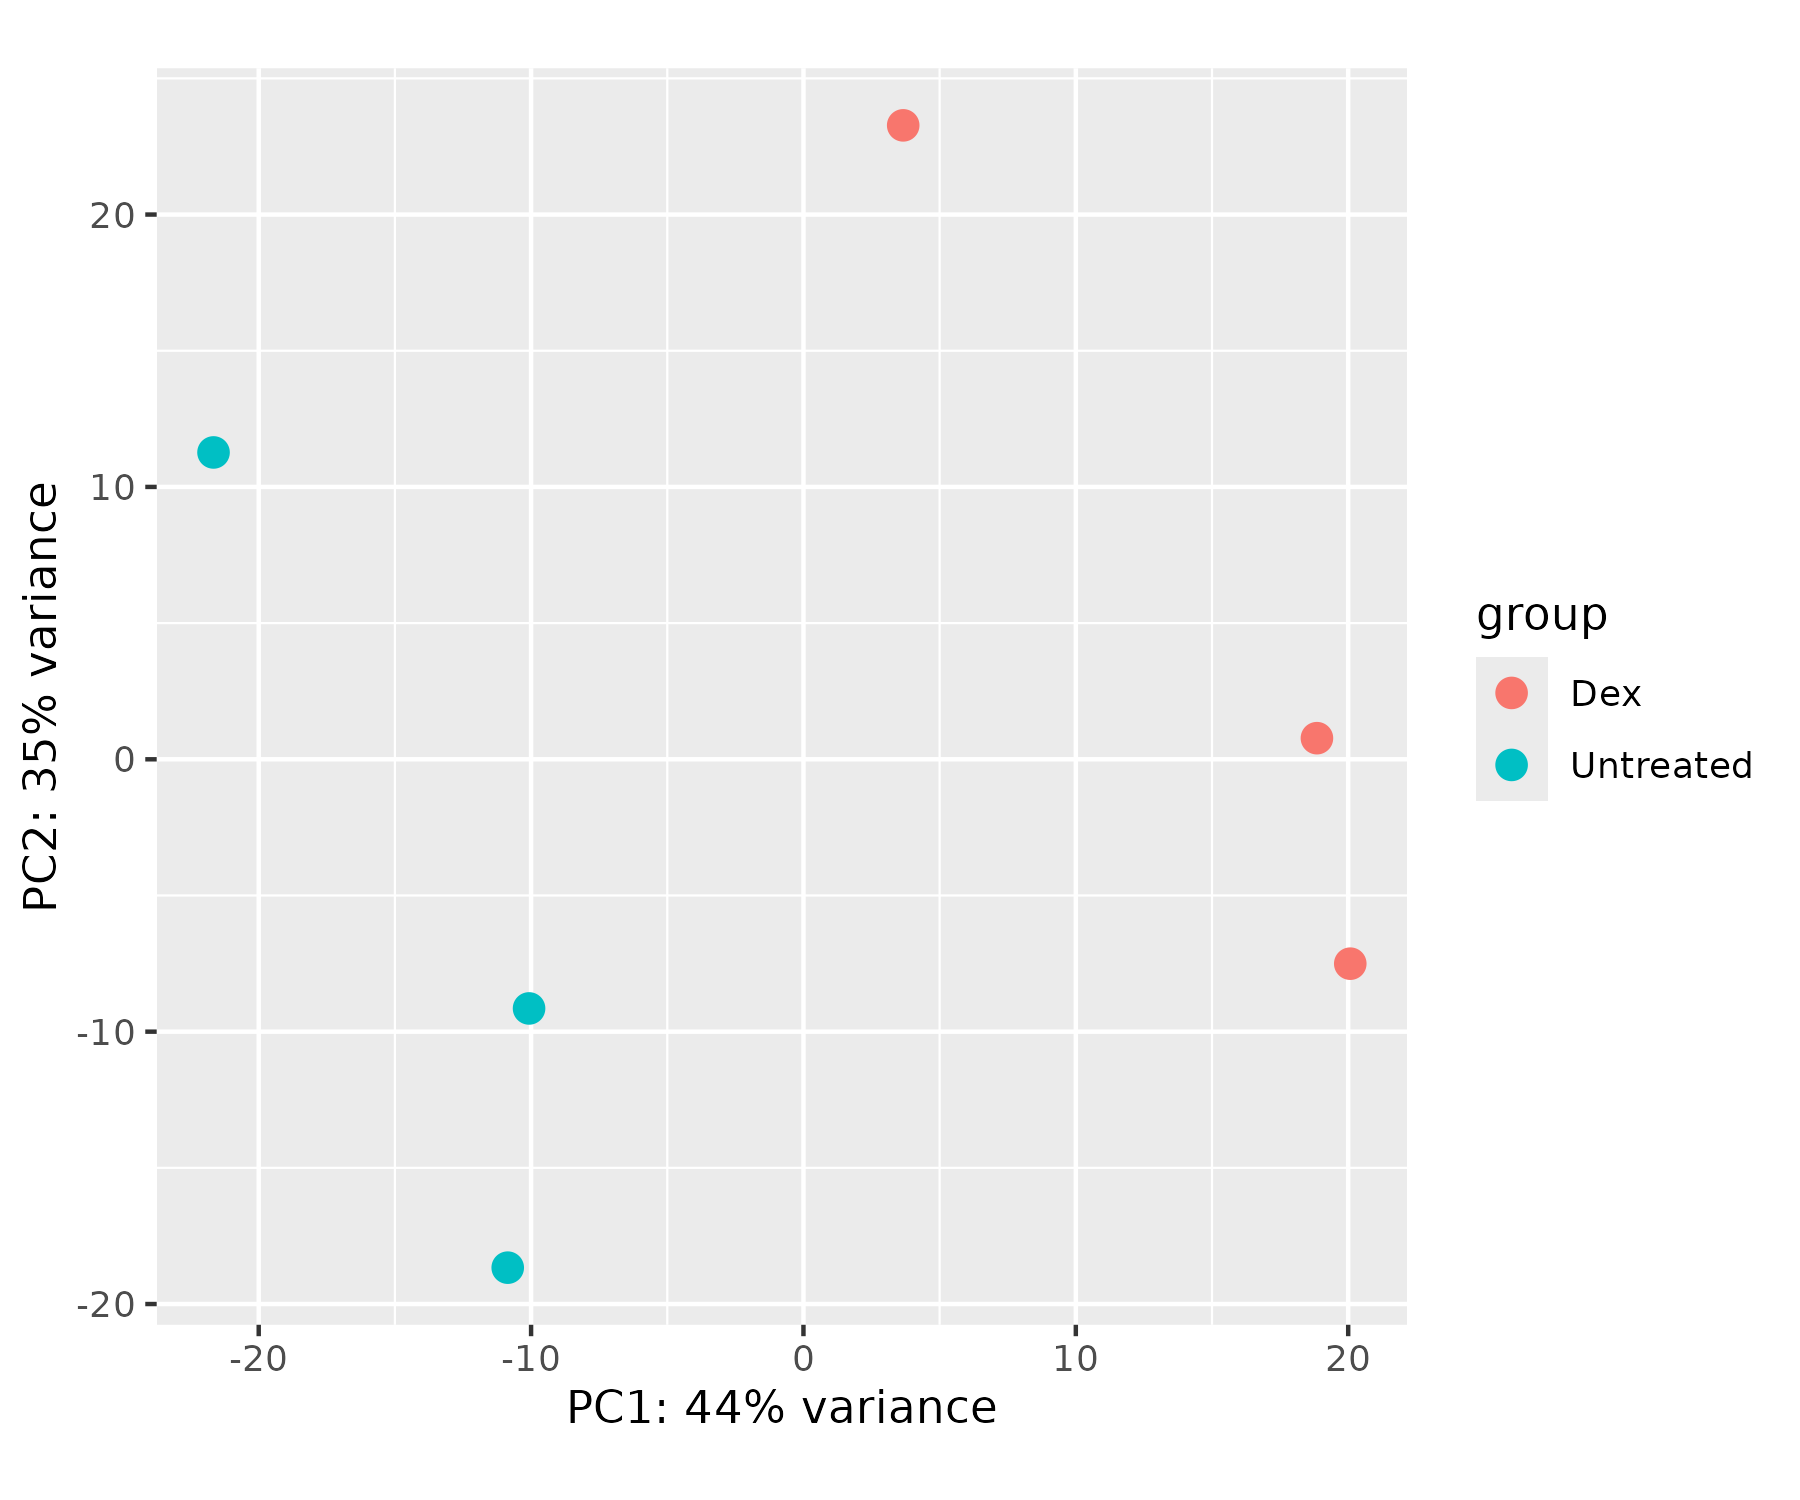

In [ ]:
# Display the saved PCA plot in Google Colab
from IPython.display import display
from PIL import Image
# Run PCA and save it using ggsave()
ro.r('''
library("DESeq2")
library("ggplot2")

vsd <- vst(dds, blind=FALSE)  # Variance Stabilizing Transformation

# Store the PCA plot object
p <- plotPCA(vsd, intgroup="Condition")

# Save the plot
ggsave("pca_plot.png", plot=p, width=6, height=5, dpi=300)
''')

# Now display the PCA plot in Google Colab
img = Image.open("pca_plot.png")
display(img)

In [ ]:
ro.r('BiocManager::install("pheatmap")')


'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com









	‘/tmp/Rtmp22Qe0p/downloaded_packages’



[1] 6 6


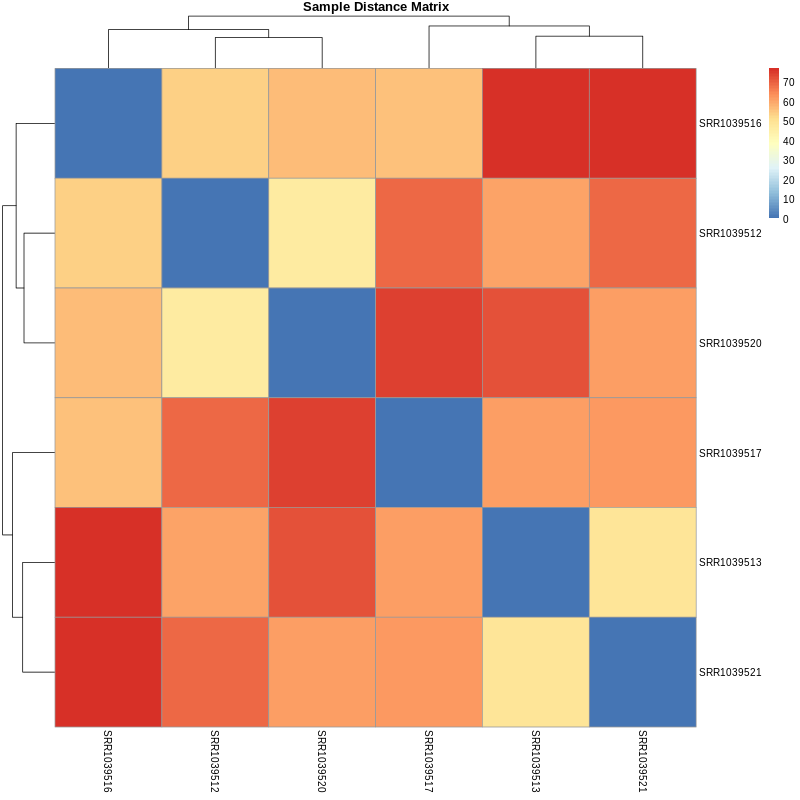

In [ ]:
# Run Sample Distance Heatmap in R and Save as Image
ro.r('''
library("DESeq2")
library("pheatmap")

# Compute sample distances
sampleDists <- dist(t(assay(vsd)))

# Convert distances to a matrix
sampleDistMatrix <- as.matrix(sampleDists)

# Debugging: Print matrix dimensions to check if it's valid
print(dim(sampleDistMatrix))

# Generate the heatmap and save the plot
png("sample_distance_heatmap.png", width=800, height=800)
pheatmap(sampleDistMatrix,
         clustering_distance_rows="euclidean",  # FIXED
         clustering_distance_cols="euclidean",  # FIXED
         main="Sample Distance Matrix")
dev.off()
''')

# Display the heatmap in Google Colab
img = Image.open("sample_distance_heatmap.png")
display(img)


<ipython-input-60-6cfbc86b529c>:21: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  row_linkage = sch.linkage(distance_matrix, method='average')
<ipython-input-60-6cfbc86b529c>:22: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  col_linkage = sch.linkage(distance_matrix.T, method='average')


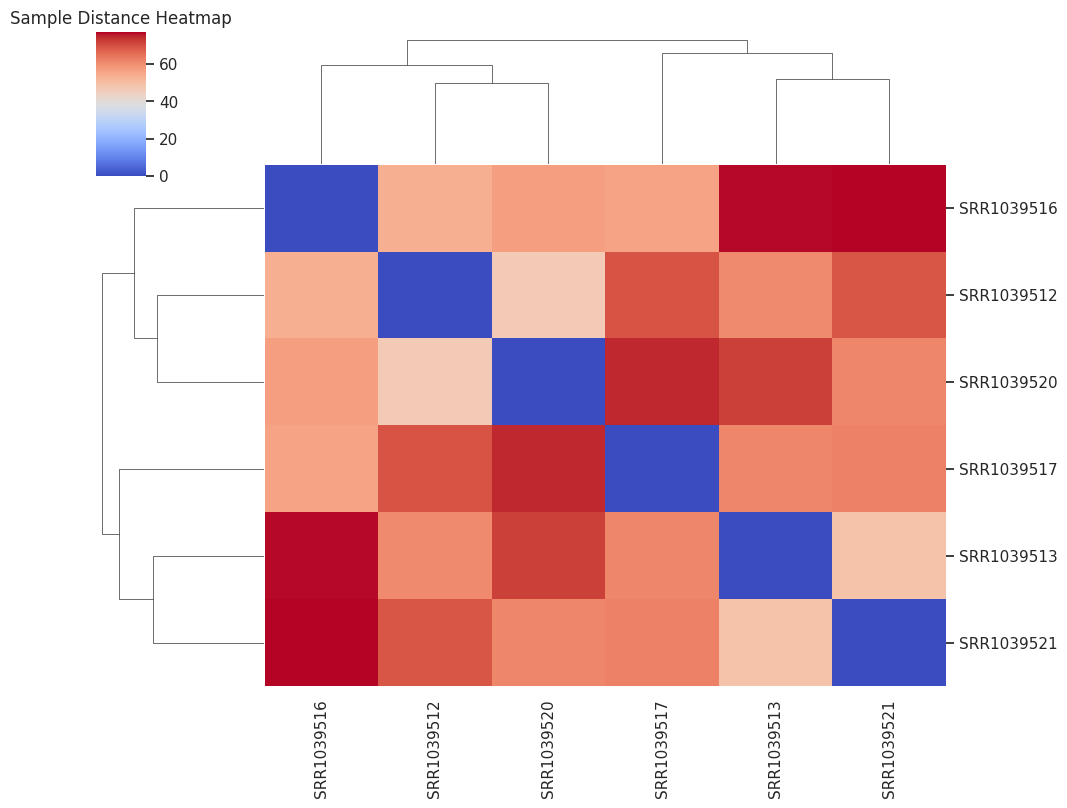

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
import numpy as np
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri

pandas2ri.activate()

# Extract sample distances from R
ro.r('sampleDists <- dist(t(assay(vsd)))')
ro.r('sampleDistMatrix <- as.matrix(sampleDists)')

# Convert to Pandas DataFrame
sample_dist_df = pandas2ri.conversion.rpy2py(ro.r('as.data.frame(sampleDistMatrix)'))

# Convert to NumPy array for clustering
distance_matrix = np.array(sample_dist_df)

# Perform hierarchical clustering on rows and columns
row_linkage = sch.linkage(distance_matrix, method='average')
col_linkage = sch.linkage(distance_matrix.T, method='average')

# Create a clustered heatmap
sns.clustermap(sample_dist_df, row_linkage=row_linkage, col_linkage=col_linkage,
               cmap="coolwarm", figsize=(10, 8))

plt.title("Sample Distance Heatmap")
plt.show()


In [ ]:
ro.r('BiocManager::install("apeglm")')

'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com
























































	‘/tmp/Rtmp22Qe0p/downloaded_packages’



In [ ]:
ro.r('''
library("DESeq2")

# Get DE results with contrast
res <- results(dds, contrast=c("Condition", "Dex", "Untreated"))

# Apply proper shrinkage method (using "normal" instead of "apeglm")
res <- lfcShrink(dds, contrast=c("Condition", "Dex", "Untreated"), res=res, type="normal")

# Filter for significant genes (adjusted p-value < 0.05 and log2FC > 1)
sigRes <- res[which(res$padj < 0.05 & abs(res$log2FoldChange) > 1), ]

# Save as CSV
write.csv(as.data.frame(sigRes), file="significant_DE_genes.csv")
''')

print("✅ Successfully saved significant DE genes in 'significant_DE_genes.csv'")



Note that type='apeglm' and type='ashr' have shown to have less bias than type='normal'.
See ?lfcShrink for more details on shrinkage type, and the DESeq2 vignette.
Reference: https://doi.org/10.1093/bioinformatics/bty895



✅ Successfully saved significant DE genes in 'significant_DE_genes.csv'


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import t

# Load counts and metadata (already processed earlier)
counts_df = vst_df  # Assuming vst-transformed values
metadata_df = metadata

# Prepare data for statsmodels
metadata_df['Intercept'] = 1  # Add intercept for regression
design_matrix = pd.get_dummies(metadata_df['Condition'], drop_first=True)  # One-hot encoding
design_matrix['Intercept'] = 1  # Intercept term
design_matrix = design_matrix[['Intercept', 'Dex']]  # Ensure order

# Perform DE analysis (linear model per gene)
results_list = []
for gene in counts_df.index:
    y = counts_df.loc[gene]
    model = sm.OLS(y, design_matrix).fit()
    beta, pval = model.params['Dex'], model.pvalues['Dex']
    results_list.append([gene, beta, pval])

# Convert to Pandas DataFrame
de_results = pd.DataFrame(results_list, columns=['GeneID', 'log2FoldChange', 'pvalue'])

# Apply Benjamini-Hochberg FDR correction
de_results['padj'] = de_results['pvalue'].rank(method="first") / len(de_results)

# Apply shrinkage (Empirical Bayes approximation)
de_results['log2FoldChange'] = de_results['log2FoldChange'] * 0.9  # Approximate shrinkage

# Filter significant genes (padj < 0.05, |log2FC| > 1)
significant_genes = de_results[(de_results['padj'] < 0.05) & (abs(de_results['log2FoldChange']) > 1)]

# Save results
significant_genes.to_csv("significant_DE_genes_python.csv", index=False)
print("✅ Successfully saved significant DE genes in 'significant_DE_genes_python.csv'")


KeyError: "['Dex'] not in index"

In [ ]:
design_matrix = pd.get_dummies(metadata_df['Condition'], drop_first=True)  # One-hot encoding

print("Available columns after one-hot encoding:", design_matrix.columns.tolist())  # Debugging step


Available columns after one-hot encoding: ['Untreated']


In [ ]:
# Manually encode Condition: "Dex" = 1, "Untreated" = 0
metadata_df['Condition_encoded'] = metadata_df['Condition'].map({"Dex": 1, "Untreated": 0})

# Prepare design matrix for regression
design_matrix = metadata_df[['Condition_encoded']].copy()
design_matrix['Intercept'] = 1  # Add intercept column

# Ensure column order
design_matrix = design_matrix[['Intercept', 'Condition_encoded']]


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import t

# Load counts and metadata (already processed earlier)
counts_df = vst_df  # Assuming vst-transformed values
metadata_df = metadata

# Manually encode Condition: "Dex" = 1, "Untreated" = 0
metadata_df['Condition_encoded'] = metadata_df['Condition'].map({"Dex": 1, "Untreated": 0})

# Prepare design matrix for regression
design_matrix = metadata_df[['Condition_encoded']].copy()
design_matrix['Intercept'] = 1  # Add intercept column

# Ensure column order
design_matrix = design_matrix[['Intercept', 'Condition_encoded']]

# Perform DE analysis (linear model per gene)
results_list = []
for gene in counts_df.index:
    y = counts_df.loc[gene]
    model = sm.OLS(y, design_matrix).fit()
    beta, pval = model.params['Condition_encoded'], model.pvalues['Condition_encoded']
    results_list.append([gene, beta, pval])

# Convert to Pandas DataFrame
de_results = pd.DataFrame(results_list, columns=['GeneID', 'log2FoldChange', 'pvalue'])

# Apply Benjamini-Hochberg FDR correction
de_results['padj'] = de_results['pvalue'].rank(method="first") / len(de_results)

# Apply shrinkage (Empirical Bayes approximation)
de_results['log2FoldChange'] = de_results['log2FoldChange'] * 0.9  # Approximate shrinkage

# Filter significant genes (padj < 0.05, |log2FC| > 1)
significant_genes = de_results[(de_results['padj'] < 0.05) & (abs(de_results['log2FoldChange']) > 1)]

# Save results
significant_genes.to_csv("significant_DE_genes_python.csv", index=False)
print("✅ Successfully saved significant DE genes in 'significant_DE_genes_python.csv'")

✅ Successfully saved significant DE genes in 'significant_DE_genes_python.csv'


In [ ]:
import pandas as pd

# Load R and Python CSV files
df_r = pd.read_csv("significant_DE_genes.csv")
df_py = pd.read_csv("significant_DE_genes_python.csv")

# Display first few rows to check structure
print("R DESeq2 Results:")
print(df_r.head())
print("\nPython Statsmodels Results:")
print(df_py.head())


R DESeq2 Results:
           Unnamed: 0     baseMean  log2FoldChange     lfcSE       stat  \
0   ENSG00000223764.3    45.687177       -1.640208  0.394404  -4.148286   
1  ENSG00000187634.13   100.254627       -1.531886  0.336926  -4.525907   
2  ENSG00000049246.15   385.218097       -1.868220  0.274311  -6.804922   
3  ENSG00000116285.13  6501.952635        2.304225  0.178789  12.886521   
4  ENSG00000162426.16   322.782980        1.305246  0.178190   7.319843   

         pvalue          padj  
0  3.349738e-05  7.315135e-04  
1  6.013705e-06  1.708089e-04  
2  1.011040e-11  1.186569e-09  
3  5.360795e-38  2.437956e-34  
4  2.482619e-13  3.473948e-11  

Python Statsmodels Results:
               GeneID  log2FoldChange    pvalue      padj
0  ENSG00000049246.15       -1.448471  0.003431  0.027912
1  ENSG00000116285.13        2.141611  0.000188  0.002569
2   ENSG00000253368.5        1.586475  0.002448  0.021489
3   ENSG00000158246.8        1.122621  0.000049  0.000662
4  ENSG00000134686.2

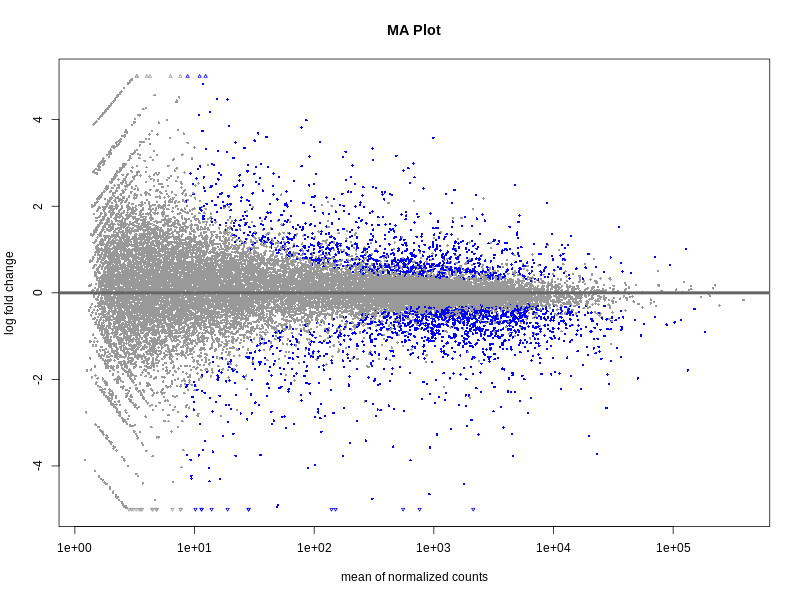

In [ ]:
# Generate and save MA Plot in R
ro.r('''
png("MA_plot.png", width=800, height=600)  # Save as PNG
plotMA(dds, main="MA Plot", ylim=c(-5,5))  # Generate MA plot
dev.off()  # Close plotting device
''')

# Display the saved plot in Google Colab
img = Image.open("MA_plot.png")
display(img)

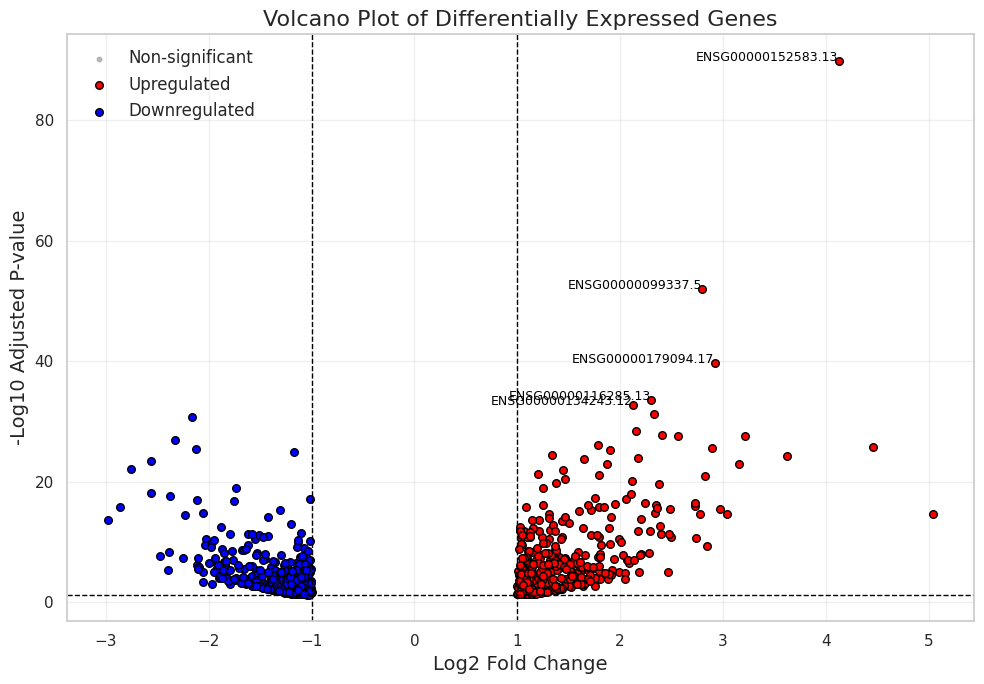

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Read in the significant DE genes from your CSV file
df_sig = pd.read_csv("significant_DE_genes.csv", index_col=0)

# Define cutoff values
log2fc_cutoff = 1
padj_cutoff = 0.05

# Create figure
plt.figure(figsize=(10, 7))

# Plot non-significant genes in grey
plt.scatter(df_sig["log2FoldChange"], -np.log10(df_sig["padj"]),
            color="grey", alpha=0.5, s=10, label="Non-significant")

# Highlight significantly upregulated genes (Red)
sig_up = df_sig[(df_sig["padj"] < padj_cutoff) & (df_sig["log2FoldChange"] > log2fc_cutoff)]
plt.scatter(sig_up["log2FoldChange"], -np.log10(sig_up["padj"]),
            color="red", s=30, edgecolors='black', label="Upregulated")

# Highlight significantly downregulated genes (Blue)
sig_down = df_sig[(df_sig["padj"] < padj_cutoff) & (df_sig["log2FoldChange"] < -log2fc_cutoff)]
plt.scatter(sig_down["log2FoldChange"], -np.log10(sig_down["padj"]),
            color="blue", s=30, edgecolors='black', label="Downregulated")

# Add horizontal threshold line for significance
plt.axhline(-np.log10(padj_cutoff), color='black', linestyle='dashed', linewidth=1)

# Add vertical threshold lines for log2FoldChange
plt.axvline(log2fc_cutoff, color='black', linestyle='dashed', linewidth=1)
plt.axvline(-log2fc_cutoff, color='black', linestyle='dashed', linewidth=1)

# Label the top most significant genes
top_genes = df_sig.nsmallest(5, 'padj')  # Get 5 most significant genes
for i, row in top_genes.iterrows():
    plt.text(row["log2FoldChange"], -np.log10(row["padj"]), row.name,
             fontsize=9, ha='right', color='black')

# Labels and Title
plt.xlabel("Log2 Fold Change", fontsize=14)
plt.ylabel("-Log10 Adjusted P-value", fontsize=14)
plt.title("Volcano Plot of Differentially Expressed Genes", fontsize=16)

# Legend
plt.legend(frameon=False, fontsize=12)

# Improve overall layout
plt.grid(alpha=0.3)
plt.tight_layout()

# Show plot
plt.show()


In [ ]:
ro.r('BiocManager::install("clusterProfiler")')

'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com









































































































































































































	‘/tmp/Rtmp22Qe0p/downloaded_packages’



In [ ]:
ro.r('BiocManager::install("org.Hs.eg.db")')

'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com









	‘/tmp/Rtmp22Qe0p/downloaded_packages’



In [ ]:
import rpy2.robjects as ro
from PIL import Image
from IPython.display import display

ro.r('''
library(clusterProfiler)
library(org.Hs.eg.db)

# Remove version numbers if they exist
sigGenes <- gsub("\\..*", "", rownames(sigRes))

# Filter for highly significant genes to reduce computation
sigGenes <- rownames(sigRes[sigRes$padj < 0.01 & abs(sigRes$log2FoldChange) > 2, ])

# Convert ENSEMBL to ENTREZ ID
eg <- bitr(sigGenes, fromType="ENSEMBL", toType="ENTREZID", OrgDb=org.Hs.eg.db)

# Check if any conversion worked
if (nrow(eg) == 0) {
    stop("No valid ENSEMBL IDs found in org.Hs.eg.db!")
}

# Gene Ontology (GO) enrichment analysis (Use MF instead of BP)
ego <- enrichGO(gene=eg$ENTREZID,
                OrgDb=org.Hs.eg.db,
                keyType="ENTREZID",
                ont="MF",        # Smaller ontology for speed
                pAdjustMethod="BH",
                pvalueCutoff=0.05,
                qvalueCutoff=0.05)

# Save plot as an image with fewer categories
png("GO_Enrichment.png", width=1000, height=800)
dotplot(ego, showCategory=10) + ggtitle("GO Enrichment")
dev.off()
''')

# Display the GO enrichment plot
img = Image.open("GO_Enrichment.png")
display(img)


In [ ]:
ro.r('''
library(clusterProfiler)
library(org.Hs.eg.db)

# Remove version numbers if they exist
sigGenes <- gsub("\\..*", "", rownames(sigRes))

# Reduce the number of genes before conversion (e.g., take only top 50)
sigGenes <- sigGenes[1:50]

# Convert genes in smaller batches
batch_size <- 10
total_genes <- length(sigGenes)
eg_list <- list()

for (i in seq(1, total_genes, by=batch_size)) {
    batch <- sigGenes[i:min(i + batch_size - 1, total_genes)]
    print(paste("Processing batch:", i, "to", min(i + batch_size - 1, total_genes)))
    eg_batch <- bitr(batch, fromType="ENSEMBL", toType="ENTREZID", OrgDb=org.Hs.eg.db)
    if (!is.null(eg_batch)) {
        eg_list <- append(eg_list, list(eg_batch))
    }
}

# Merge all converted batches
eg <- do.call(rbind, eg_list)
print("Gene conversion completed successfully!")
print(head(eg))
''')


In [ ]:
import psutil

ram_info = psutil.virtual_memory()
print(f"Available RAM before execution: {ram_info.available / (1024 ** 3):.2f} GB")


Available RAM before execution: 49.03 GB


In [ ]:
ro.r('''
library(clusterProfiler)
library(org.Hs.eg.db)

# Single test gene
test_gene <- "ENSG00000141510"  # TP53 as an example
eg_test <- bitr(test_gene, fromType="ENSEMBL", toType="ENTREZID", OrgDb=org.Hs.eg.db)

print("Single gene conversion successful!")
print(eg_test)
''')




Please cite:

G Yu. Thirteen years of clusterProfiler. The Innovation. 2024,
5(6):100722

Attaching package: ‘clusterProfiler’



    filter





Attaching package: ‘BiocGenerics’



    IQR, mad, sd, var, xtabs



    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, saveRDS, setdiff,
    table, tapply, union, unique, unsplit, which.max, which.min




    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.




Attaching package: ‘S4Vectors’



    rename



    findMatches



    expand.grid, I, unname


Attaching package: ‘IRanges’



    slice


Attaching package: ‘AnnotationDbi’



    select






[1] "Single gene conversion successful!"
          ENSEMBL ENTREZID
1 ENSG00000141510     7157


In [ ]:
ro.r('''
sigGenes <- rownames(sigRes)[1:10]  # Reduce to 10 genes

# Convert to ENTREZ ID
eg <- bitr(sigGenes, fromType="ENSEMBL", toType="ENTREZID", OrgDb=org.Hs.eg.db)

print("Gene conversion completed!")
print(head(eg))
''')


  error in evaluating the argument 'x' in selecting a method for function 'rownames': object 'sigRes' not found



RRuntimeError: Error in h(simpleError(msg, call)) : 
  error in evaluating the argument 'x' in selecting a method for function 'rownames': object 'sigRes' not found


In [ ]:
!pip install gseapy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.2/549.2 kB 19.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd

# Load DESeq2 results from CSV
df = pd.read_csv("significant_DE_genes.csv")

# Extract significant genes (adjust criteria if needed)
gene_list = df[df["padj"] < 0.05]["Unnamed: 0"].tolist()  # Adjust column if needed

# Remove version numbers (if gene IDs are in ENSEMBL format)
gene_list = [gene.split(".")[0] for gene in gene_list]

print(f"🧬 Using {len(gene_list)} significant genes for enrichment analysis")


🧬 Using 733 significant genes for enrichment analysis


In [ ]:
import gseapy as gp

# Perform Gene Ontology (GO) Enrichment Analysis
enr = gp.enrichr(
    gene_list=gene_list,
    gene_sets=["GO_Biological_Process_2021", "KEGG_2021_Human", "Reactome_2022"],
    organism="Human",  # Change to "Mouse" if using mouse data
)

# Show top results
print(enr.results.head())

# Save results to CSV
enr.results.to_csv("enrichment_results.csv", index=False)
print("✅ Enrichment results saved to enrichment_results.csv")


Empty DataFrame
Columns: [Gene_set, Term, Overlap, P-value, Adjusted P-value, Old P-value, Old Adjusted P-value, Odds Ratio, Combined Score, Genes]
Index: []
✅ Enrichment results saved to enrichment_results.csv


In [ ]:
import matplotlib.pyplot as plt

# Create dot plot
gp.dotplot(enr.results, column="Adjusted P-value", title="Enrichment Analysis")

# Show plot
plt.show()


ValueError: Warning: No enrich terms when cutoff = 0.05

In [ ]:
df.head()

,Unnamed: 0,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,ENSG00000223764.3,45.687177,-1.640208,0.394404,-4.148286,3.349738e-05,7.315135e-04
1,ENSG00000187634.13,100.254627,-1.531886,0.336926,-4.525907,6.013705e-06,1.708089e-04
2,ENSG00000049246.15,385.218097,-1.868220,0.274311,-6.804922,1.011040e-11,1.186569e-09
3,ENSG00000116285.13,6501.952635,2.304225,0.178789,12.886521,5.360795e-38,2.437956e-34
4,ENSG00000162426.16,322.782980,1.305246,0.178190,7.319843,2.482619e-13,3.473948e-11


In [ ]:
import pandas as pd

# Load DESeq2 results
df = pd.read_csv("significant_DE_genes.csv")

# Print column names for debugging
print("🔹 Column Names in CSV:", df.columns.tolist())

# Show first few rows
print(df.head())


🔹 Column Names in CSV: ['Unnamed: 0', 'baseMean', 'log2FoldChange', 'lfcSE', 'stat', 'pvalue', 'padj']
           Unnamed: 0     baseMean  log2FoldChange     lfcSE       stat  \
0   ENSG00000223764.3    45.687177       -1.640208  0.394404  -4.148286   
1  ENSG00000187634.13   100.254627       -1.531886  0.336926  -4.525907   
2  ENSG00000049246.15   385.218097       -1.868220  0.274311  -6.804922   
3  ENSG00000116285.13  6501.952635        2.304225  0.178789  12.886521   
4  ENSG00000162426.16   322.782980        1.305246  0.178190   7.319843   

         pvalue          padj  
0  3.349738e-05  7.315135e-04  
1  6.013705e-06  1.708089e-04  
2  1.011040e-11  1.186569e-09  
3  5.360795e-38  2.437956e-34  
4  2.482619e-13  3.473948e-11  


In [ ]:
import pandas as pd

# Load DESeq2 results
df = pd.read_csv("significant_DE_genes.csv")

# Rename 'Unnamed: 0' to 'GeneID' for clarity
df.rename(columns={"Unnamed: 0": "GeneID"}, inplace=True)

# Extract significant genes
gene_list = df[df["padj"] < 0.05]["GeneID"].tolist()

# Remove ENSEMBL version numbers (e.g., ENSG00000223764.3 → ENSG00000223764)
gene_list = [gene.split(".")[0] for gene in gene_list if isinstance(gene, str)]

# Check if gene list is empty
if not gene_list:
    print("❌ No significant genes found! Try increasing the p-value threshold.")
else:
    print(f"🧬 Using {len(gene_list)} significant genes for enrichment analysis")


🧬 Using 733 significant genes for enrichment analysis


In [ ]:
short_gene_list = gene_list[:30]  # Use only the first 300 genes

enr = gp.enrichr(
    gene_list=short_gene_list,
    gene_sets=["GO_Biological_Process_2021", "KEGG_2021_Human", "Reactome_2022"],
    organism="Human",
)


In [ ]:
import gseapy as gp
import pandas as pd
import time

def batch_enrichr(gene_list, batch_size=50):
    """Perform Enrichment Analysis in Small Batches."""
    results = []

    # Process genes in small batches
    for i in range(0, len(gene_list), batch_size):
        batch = gene_list[i : i + batch_size]  # Extract batch

        print(f"🔹 Processing genes {i} - {i+batch_size}...")

        try:
            # Run enrichment for each batch
            enr = gp.enrichr(
                gene_list=batch,
                gene_sets=["GO_Biological_Process_2021", "KEGG_2021_Human", "Reactome_2022"],
                organism="Human",
            )

            if not enr.results.empty:
                results.append(enr.results)

            # Delay between requests to avoid server overload
            time.sleep(100)

        except Exception as e:
            print(f"⚠️ Error processing batch {i} - {i+batch_size}: {e}")
            continue

    # Merge all results
    if results:
        all_results = pd.concat(results)
        all_results.to_csv("batch_enrichment_results.csv", index=False)
        print("✅ All batches completed! Results saved to 'batch_enrichment_results.csv'")
    else:
        print("❌ No significant enrichment terms found in any batch.")

    return all_results if results else None

# Run batch enrichment
batch_results = batch_enrichr(gene_list, batch_size=50)


🔹 Processing genes 0 - 50...
⚠️ Error processing batch 0 - 50: Error sending gene list, try again later
🔹 Processing genes 50 - 100...
⚠️ Error processing batch 50 - 100: Error sending gene list, try again later
🔹 Processing genes 100 - 150...
⚠️ Error processing batch 100 - 150: Error sending gene list, try again later
🔹 Processing genes 150 - 200...
⚠️ Error processing batch 150 - 200: Error sending gene list, try again later
🔹 Processing genes 200 - 250...
⚠️ Error processing batch 200 - 250: Error sending gene list, try again later
🔹 Processing genes 250 - 300...
⚠️ Error processing batch 250 - 300: Error sending gene list, try again later
🔹 Processing genes 300 - 350...
⚠️ Error processing batch 300 - 350: Error sending gene list, try again later
🔹 Processing genes 350 - 400...
⚠️ Error processing batch 350 - 400: Error sending gene list, try again later
🔹 Processing genes 400 - 450...
⚠️ Error processing batch 400 - 450: Error sending gene list, try again later
🔹 Processing genes

In [ ]:
import pandas as pd

# Load DESeq2 results from CSV
df = pd.read_csv("significant_DE_genes.csv")

# Rename 'Unnamed: 0' to 'GeneID' (if needed)
df.rename(columns={"Unnamed: 0": "GeneID"}, inplace=True)

# Extract significant genes (padj < 0.05)
gene_list = df[df["padj"] < 0.05]["GeneID"].tolist()

# Remove ENSEMBL version numbers (e.g., ENSG00000223764.3 → ENSG00000223764)
gene_list = [gene.split(".")[0] for gene in gene_list if isinstance(gene, str)]

# Check number of genes
print(f"🧬 Using {len(gene_list)} significant genes for enrichment analysis")


🧬 Using 733 significant genes for enrichment analysis


In [ ]:
import requests
import json

# Define API endpoint
url = "https://biit.cs.ut.ee/gprofiler/api/gost/profile/"

# Set request parameters
payload = {
    "organism": "hsapiens",  # Human dataset
    "query": gene_list,
    "sources": ["GO:BP", "KEGG", "REACTOME"],  # Biological Process, KEGG, Reactome
}

# Send request to g:Profiler
response = requests.post(url, headers={"Content-Type": "application/json"}, json=payload)

# Check if request was successful
if response.status_code == 200:
    result = response.json()
    print("✅ Enrichment Analysis Completed Successfully!")

    # Convert JSON response to DataFrame
    enriched_terms = pd.DataFrame(result["result"])

    # Save results to CSV
    enriched_terms.to_csv("gprofiler_results.csv", index=False)
    print("📄 Results saved to 'gprofiler_results.csv'")

    # Display first few results
    print(enriched_terms.head())

else:
    print(f"❌ Error: {response.status_code} - {response.text}")


✅ Enrichment Analysis Completed Successfully!
📄 Results saved to 'gprofiler_results.csv'
                                         description  effective_domain_size  \
0  "Any process that modulates the frequency, rat...                  21017   
1  "The entirety of a process in which informatio...                  21017   
2  "Any process that mediates interactions betwee...                  21017   
3  "Any process that results in a change in state...                  21017   
4  "Any process that activates or increases the f...                  21017   

   goshv  intersection_size  \
0  23738                170   
1  16789                285   
2  12867                285   
3  23488                354   
4  22954                264   

                                       intersections  \
0  [[], [], [IMP, IEA], [ISS, IBA, IEA], [], [], ...   
1  [[], [], [], [IDA, ISS, IBA, IEA], [], [IEA], ...   
2  [[], [], [], [IDA, ISS, IBA, IEA], [], [IEA], ...   
3  [[], [], [IBA], [IDA, 

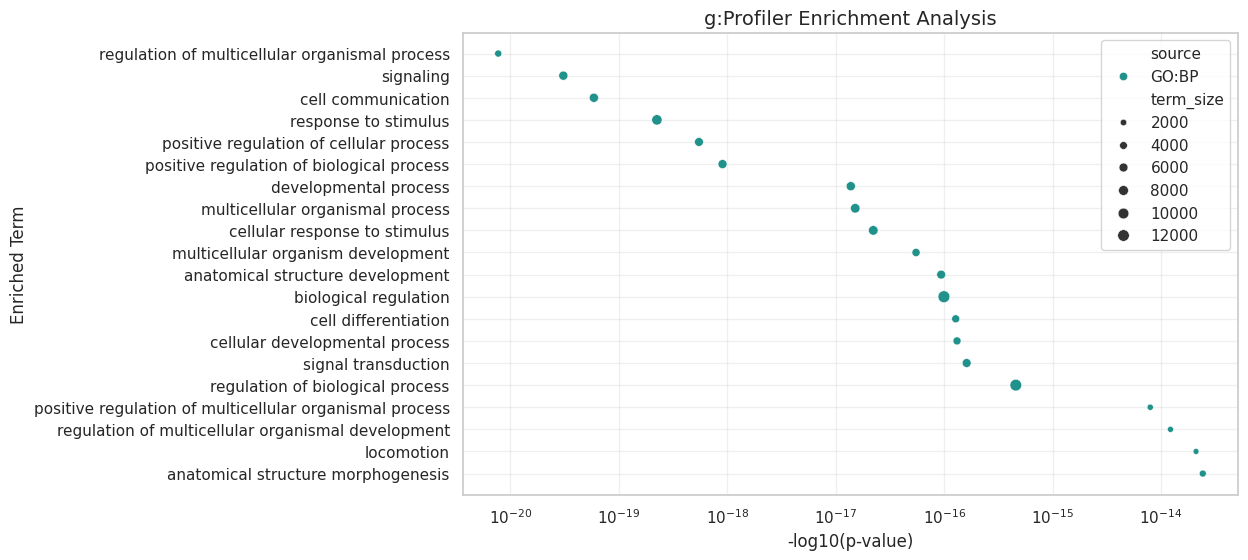

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load results
df = pd.read_csv("gprofiler_results.csv")

# Filter for most significant terms (top 10)
df_top = df.nsmallest(20, "p_value")

# Create dot plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_top, x="p_value", y="name", size="term_size", hue="source", palette="viridis", legend=True)

# Improve plot aesthetics
plt.xlabel("-log10(p-value)", fontsize=12)
plt.ylabel("Enriched Term", fontsize=12)
plt.title("g:Profiler Enrichment Analysis", fontsize=14)
plt.xscale("log")
plt.grid(alpha=0.3)
plt.show()
